# MUVA 2022/23 - Imagen Médica
# Práctica 1 - Apartado 3
## Grupo 4
### Pablo Ríos, Celia García.

**Cálculo de mapas de hierro del cerebro en MRI**

*El objetivo de este apartado consiste en calcular un mapa de T2 a partir de una serie de imágenes de resonancia magnética adquiridas con distintos tiempos de eco (𝑇1).*

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse

from typing import List, Tuple

In [25]:
def plot_imgs(images: List[np.array], titles: List[str], title:str = '', size: Tuple = (15, 4)):

    fig, axes = plt.subplots(nrows=1, ncols=len(images), figsize= size)
    fig.suptitle(title)

    for i, (image, title) in enumerate(zip(images, titles)):
        ax = axes[i]
        ax.imshow(image, cmap='gray')
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

## 3.1 Se pide ajustar a cada píxel de la imagen una exponencial, y obtener una imagen que represente 𝑇2 en cada píxel.

*Para cada px de las imagenes, debemos hacer ese ajuste de mínimos cuadrados, habiendo hecho antes Ln, y representar el valor de T2 en el mapa T2. Resultado será una img del mismo tamaño pero me muestra otra cosa.*

### Leemos las imágenes

In [40]:
# Lista de nombres
mri_names = [(img_name) for img_name in os.listdir('./Hierro/') if img_name.startswith('Hierro')] # (8,)
# Sacamos el TE de cada iamgen, por su nombre
TE = [(int(mri_names[i].split('TE')[1].split('.')[0])) for i in range(len(mri_names))] # (8,) # [20, 70, 35, 105, 40, 60, 140, 80]

# Ordenamos las listas de nombres y de TE
names_sorted = [name for _, name in sorted(zip(TE, mri_names))]
TE_sorted = sorted(TE) # lo ordenamos

# lista de 8 imgs ordenadas
mri_imgs = [(cv2.imread('./Hierro/' + mri, 0)) for mri in names_sorted] # (8, 256, 256)


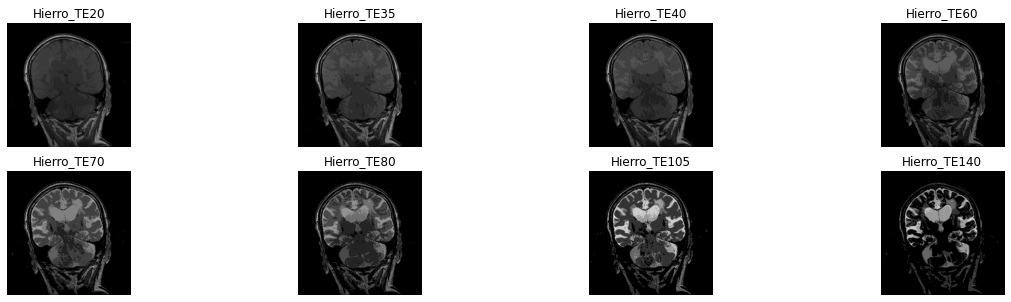

In [41]:
# Visualizamos
fig = plt.figure(figsize=(20,5))
for k in range (0,len(mri_imgs)):    
    temp = 241 + k  
    ax = plt.subplot(temp)
    ax.imshow(mri_imgs[k], cmap='gray')
    plt.title(names_sorted[k].split('.')[0])
    plt.axis('off')

### Implementamos la teoría 

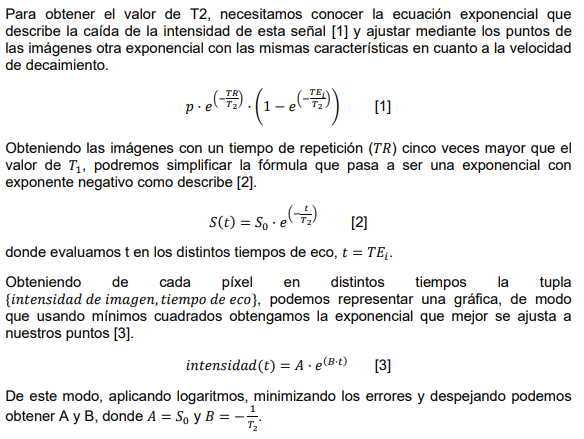

In [56]:
h, w = mri_imgs[0].shape
# Inicializamos el resultado
R2 = np.zeros((h, w))
# Recorremos todas las imgs y todos los pixeles
for i in range(h):
    for j in range(w):
        # primer px de las 8 imagenes, segundo px de las 8 imgs, etc....
        S = np.array([(mri_imgs[l][i, j]) for l in range(len(mri_imgs))]) #(8,)

        # Eliminamos un px cuando su valor de intensidad es 0
        S_refined = np.delete(S, np.where(S == 0)) #(8,)
        # También eliminamos ese valor de TE para que cuadre.
        TE_refined = np.delete(TE_sorted, np.where(S == 0)) #(8,)

        # Si tenemos al menos 2 valores
        # Hacemos optimización de mínimos cuadrados, aplicando Ln a ambos lados de la expresión [3]
        # Ln(S) = Ln(A)+B*TE
        if len(S_refined) >= 2:
            log_S = np.log(S_refined, dtype=np.float64)
            # Despejamos B y Ln(A)
            B, ln_A = np.polyfit(TE_refined, log_S, 1, w = np.sqrt(S_refined))
            R2[i, j] = - B

### Normalizamos las imágenes resultado


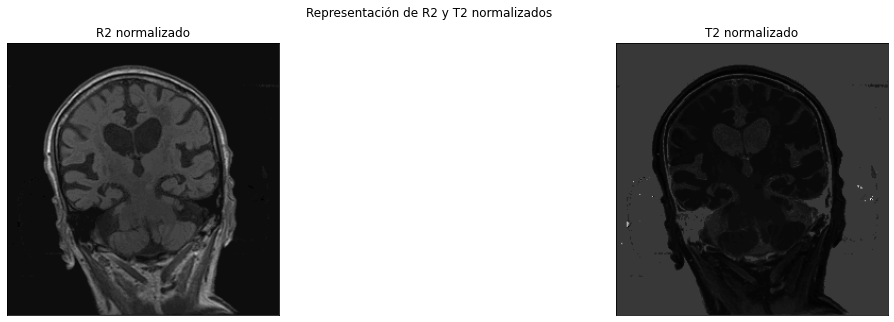

In [55]:

R2_norm = (((R2 - np.min(R2)) / (np.max(R2) - np.min(R2))) * 255).astype(np.uint8)

T2 = np.zeros((h, w))
T2[R2_norm != 0] = 1 / R2_norm[R2_norm != 0]
T2_norm = (T2 * 255).astype(np.uint8)

R2_norm = (R2 - np.min(R2)) / (np.max(R2) - np.min(R2)) 
R2_norm = (R2_norm * 255).astype(np.uint8)

T2 = np.zeros((h, w))
T2[R2_norm != 0] =  1 / R2_norm[R2_norm != 0]
T2_norm = (T2 * 255).astype(np.uint8)

images = [R2_norm, T2_norm]
titles = ['R2 normalizado','T2 normalizado']
plot_imgs(images, titles, 'Representación de R2 y T2 normalizados', (20, 5))
